# **Tugas 2 Deep Learning**

Proyek ini bertujuan untuk melakukan analisis sentimen biner (positif dan negatif) pada teks berbahasa Indonesia. Fokus utamanya adalah membandingkan performa dua arsitektur Recurrent Neural Network (RNN) yang berbeda, yaitu **SimpleRNN** dan **Long Short-Term Memory (LSTM)**.

Untuk meningkatkan kualitas dan kecepatan pelatihan, model akan memanfaatkan *pre-trained word embedding* dari **FastText (cc.id.300.vec)** yang sudah memiliki pemahaman semantik kata-kata dalam bahasa Indonesia. Arsitektur yang digunakan adalah **Many-to-One**, di mana sekuens kata-kata dari sebuah kalimat akan dipetakan ke satu output tunggal yang merepresentasikan sentimennya.

Proyek ini mencakup beberapa tahapan utama:
1.  **Setup Lingkungan**: Mengunduh pre-trained embedding FastText dan menginstal semua library yang diperlukan.
2.  **Pemuatan dan Pra-pemrosesan Data**: Mengambil dataset sentimen dari repositori publik, membersihkan teks, melakukan tokenisasi, dan padding.
3.  **Pembangunan Model**: Merancang arsitektur untuk SimpleRNN dan LSTM yang menggunakan embedding layer non-trainable dari FastText.
4.  **Pelatihan dan Evaluasi**: Melatih kedua model pada dataset yang sama dan membandingkan hasilnya melalui metrik klasifikasi serta visualisasi loss dan accuracy.

## **Install & Import Libraries**
## 1. Setup Lingkungan dan Unduh Word Embedding

Langkah pertama dalam proyek ini adalah mempersiapkan lingkungan kerja. Ini mencakup instalasi library esensial seperti `TensorFlow` untuk membangun model deep learning dan `Sastrawi` untuk pemrosesan teks bahasa Indonesia.

Bagian paling krusial di tahap ini adalah mengunduh **pre-trained word embedding dari FastText (`cc.id.300.vec.gz`)**. File ini berisi vektor 300 dimensi untuk jutaan kata dalam bahasa Indonesia. Dengan menggunakan embedding ini, model kita tidak perlu belajar representasi kata dari awal, melainkan langsung memanfaatkan pengetahuan semantik yang sudah ada. Proses ini secara signifikan dapat meningkatkan performa, terutama pada dataset yang tidak terlalu besar.

Kode di bawah ini dirancang untuk efisiensi: ia akan memeriksa apakah file embedding sudah ada sebelum mengunduh. Setelah diunduh, file arsip `.gz` akan diekstrak dan kemudian dihapus untuk menghemat ruang penyimpanan.

In [1]:
import requests
import gzip
import shutil
import os

# URL dan nama file
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"
gz_filename = "cc.id.300.vec.gz"
vec_filename = "cc.id.300.vec"

# Fungsi untuk menampilkan progress bar
def download_with_progress(url, filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get('content-length', 0))
        block_size = 8192
        with open(filename, 'wb') as f:
            from tqdm.notebook import tqdm
            with tqdm(total=total_size, unit='iB', unit_scale=True, desc=filename) as pbar:
                for chunk in r.iter_content(chunk_size=block_size):
                    pbar.update(len(chunk))
                    f.write(chunk)
    return total_size

try:
    # Cek apakah file final sudah ada
    if os.path.exists(vec_filename):
        print(f"✅ File '{vec_filename}' sudah ada. Tidak perlu mengunduh lagi.")
    else:
        # --- Langkah 1: Mengunduh file ---
        print(f"📥 Mengunduh file dari {url}...")
        if not os.path.exists(gz_filename):
            download_with_progress(url, gz_filename)
            print(f"✅ File '{gz_filename}' berhasil diunduh.")
        else:
            print(f"File '{gz_filename}' sudah ada. Melewati proses unduh.")

        # --- Langkah 2: Mengekstrak file .gz ---
        print(f"⚙️ Mengekstrak '{gz_filename}'... (Proses ini mungkin memakan waktu beberapa menit)")
        with gzip.open(gz_filename, 'rb') as f_in:
            with open(vec_filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"✅ Ekstraksi selesai. File '{vec_filename}' telah dibuat.")

        # --- Langkah 3: Hapus file .gz untuk menghemat ruang ---
        os.remove(gz_filename)
        print(f"🗑️ File '{gz_filename}' telah dihapus untuk menghemat ruang.")

except Exception as e:
    print(f"❌ Terjadi kesalahan: {e}")

📥 Mengunduh file dari https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz...


cc.id.300.vec.gz:   0%|          | 0.00/1.23G [00:00<?, ?iB/s]

✅ File 'cc.id.300.vec.gz' berhasil diunduh.
⚙️ Mengekstrak 'cc.id.300.vec.gz'... (Proses ini mungkin memakan waktu beberapa menit)
✅ Ekstraksi selesai. File 'cc.id.300.vec' telah dibuat.
🗑️ File 'cc.id.300.vec.gz' telah dihapus untuk menghemat ruang.


In [2]:
!pip install numpy pandas scikit-learn nltk matplotlib seaborn
!pip install tensorflow==2.19.0

In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.8 MB/s eta 0:00:00


In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf # Import tensorflow with alias tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional, BatchNormalization # Import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW # Import RMSprop and AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## **Clone Dan Load Sentiment Dataset**
## 2. Pemuatan dan Pra-pemrosesan Dataset Sentimen

### A. Pemuatan dan Penggabungan Data

Dataset yang digunakan untuk melatih model sentimen ini berasal dari repositori publik di GitHub yang berisi kumpulan data sentimen berbahasa Indonesia.
**Dataset Pilkada DKI 2017**: Berisi tweet terkait sentimen publik terhadap pasangan calon.

Dataset analisis sentimen dikumpulkan dari situs jejaring sosial Twitter terkait dengan pelaksanaan Pemilihan Gubernur DKI Jakarta Tahun 2017 sejumlah 900 dokumen tweet dari 3 pasangan calon yaitu Agus-Sylvi, Ahok-Djarot, & Anies-Sandi. Dataset memiliki 2 kelas sentimen yaitu positive dan negative

In [5]:
import os
import pandas as pd

# Clone repo jika belum ada
if not os.path.exists('Dataset-Sentimen-Analisis-Bahasa-Indonesia'):
    !git clone https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia.git
else:
    print("✅ Repository sudah ada, skip clone.")

# Dataset Pilkada
csv_pilkada = 'Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_pilkada_DKI_2017.csv'
try:
    df1 = pd.read_csv(csv_pilkada, encoding='utf-8')
except:
    df1 = pd.read_csv(csv_pilkada, encoding='latin1')

df1 = df1.dropna(subset=['Text Tweet', 'Sentiment'])
df1['Sentiment'] = df1['Sentiment'].str.lower().str.strip()
df1 = df1[['Sentiment', 'Text Tweet']]  # Ambil kolom yang diperlukan


print(f"✅ Dataset : {df1.shape[0]} baris")
print(df1['Sentiment'].value_counts())
print("\n🔎 Sample:")
df1.head(10)


Cloning into 'Dataset-Sentimen-Analisis-Bahasa-Indonesia'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 169 (delta 24), reused 0 (delta 0), pack-reused 123 (from 1)
Receiving objects: 100% (169/169), 164.89 KiB | 1.77 MiB/s, done.
Resolving deltas: 100% (80/80), done.
✅ Dataset : 900 baris
Sentiment
negative    450
positive    450
Name: count, dtype: int64

🔎 Sample:


,Sentiment,Text Tweet
0,negative,Banyak akun kloning seolah2 pendukung #agussil...
1,negative,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,negative,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,negative,Kasian oh kasian dengan peluru 1milyar untuk t...
4,negative,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...
5,negative,aneh deh lebay masa ini di sangkut pautkan sam...
6,negative,Kepada Allah SWT kami ucapkan rasa syukur dan ...
7,negative,Terima Kasih teruntuk pendukung #AHY #SYLVI ka...
8,negative,Trima Kasih atas KeIstiqomahan Relawan #AHY @A...
9,negative,Mengenang pidato kekalahan #ahy


### **Preprocess Sentiment Data**

In [6]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

# Pastikan stopwords NLTK sudah diunduh
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Hapus mention dan hashtag (tapi simpan isi kata hashtag)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    # Hapus angka berlebihan
    text = re.sub(r'\d+', '', text)
    # Hapus tanda baca dan karakter non-alfabet
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()


    return text # Added return statement

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
print("\n📊 Preprocessing Sentiment Data...")

print("\n📊 Preprocessing Sentiment Data...")

# --- 1️⃣ Ambil teks dan label dari Data Pilkada 2017 ---
texts_sentimen = df1['Text Tweet'].tolist()  # <-- PERBAIKAN
labels_sentimen = df1['Sentiment'].tolist() # <-- PERBAIKAN
label_column = 'Sentiment'

# --- 2️⃣ Bersihkan teks (kode ini sudah benar) ---
print("🧼 Cleaning texts...")
texts_sentimen = [clean_text(t) for t in texts_sentimen]
print("✅ Contoh hasil bersih:")
print(texts_sentimen[:5])

# --- 3️⃣ Cek label unik dan mapping dari DATA GABUNGAN ---
unique_labels = sorted(df1[label_column].str.lower().str.strip().unique()) # <-- PERBAIKAN
print(f"Label unik ditemukan: {unique_labels}")

# Sisa kode di bawah ini sudah benar dan tidak perlu diubah
label_order = ['negative', 'positive']
label_to_id = {label: idx for idx, label in enumerate(label_order) if label in unique_labels}
id_to_label = {idx: label for label, idx in label_to_id.items()}

y_sentimen = np.array([label_to_id[label] for label in labels_sentimen if label in label_to_id])
num_classes = len(label_to_id)
print(f"Label mapping: {label_to_id}")
print(f"Number of classes: {num_classes}")

# --- 4️⃣ Split dulu sebelum fit tokenizer
X_train_texts, X_test_texts, y_train_s, y_test_s = train_test_split(
    texts_sentimen, y_sentimen, test_size=0.2, random_state=42, stratify=y_sentimen
)

# --- 5️⃣ Fit tokenizer only on the training data
tokenizer_sentimen = Tokenizer(oov_token="<OOV>", lower=True)
tokenizer_sentimen.fit_on_texts(X_train_texts)

vocab_size_sentimen = len(tokenizer_sentimen.word_index) + 1

# --- 6️⃣ Convert text to sequence
X_train_seq = tokenizer_sentimen.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer_sentimen.texts_to_sequences(X_test_texts)

# --- 7️⃣ Calculate sequence length from train data only
seq_lengths_train = [len(seq) for seq in X_train_seq]
max_len_sentimen = int(np.percentile(seq_lengths_train, 95))  # 95th percentile from TRAIN

# --- 8️⃣ Padding
X_train_s = pad_sequences(X_train_seq, maxlen=max_len_sentimen, padding='post', truncating='post')
X_test_s = pad_sequences(X_test_seq, maxlen=max_len_sentimen, padding='post', truncating='post')

print(f"Vocab size: {vocab_size_sentimen}")
print(f"Max sequence length (95th percentile): {max_len_sentimen}")
print(f"X_train shape: {X_train_s.shape}, X_test shape: {X_test_s.shape}")


📊 Preprocessing Sentiment Data...

📊 Preprocessing Sentiment Data...
🧼 Cleaning texts...
✅ Contoh hasil bersih:
['banyak akun kloning seolah pendukung agussilvy mulai menyerang paslon aniessandi dengan opini dan argumen pmbenaranjangan terkecoh', 'agussilvy bicara apa kasihan yaalap itu air matanya wkwkwkwk', 'kalau aku sih gak nunggu hasil akhir qc tp lagi nunggu motif cuitan pak kayak apa pasca agussilvy nyungsep', 'kasian oh kasian dengan peluru milyar untuk tiap rw agussilvy tidak mempan menangin pilkada quickcount pilkadaserentak', 'maaf ya pendukung agussilvyhayo dukung aniessandi diputaran']
Label unik ditemukan: ['negative', 'positive']
Label mapping: {'negative': 0, 'positive': 1}
Number of classes: 2
Vocab size: 2951
Max sequence length (95th percentile): 22
X_train shape: (720, 22), X_test shape: (180, 22)


### **Build RNN dan LSTM Classifier (Many-to-One)**
## 3. Pembangunan dan Pelatihan Model RNN & LSTM

Tahap ini adalah inti dari proyek, di mana dua model sekuensial—SimpleRNN dan LSTM—akan dibangun, dikompilasi, dan dilatih.

### A. Persiapan Embedding Layer (FastText)

Sebelum model dibangun, kita perlu membuat "jembatan" antara vokabulari dataset kita dengan vektor dari FastText. Ini dilakukan dengan menciptakan sebuah **embedding matrix**. Matriks ini akan memiliki dimensi `(ukuran_vokabulari, 300)`, di mana setiap barisnya sesuai dengan indeks kata dalam tokenizer dan berisi vektor 300 dimensi kata tersebut dari FastText.

Matriks ini kemudian akan dimuat sebagai *weights* awal untuk layer `Embedding` di kedua model, dan layer tersebut akan diatur sebagai `trainable=False`. Artinya, model tidak akan memperbarui bobot embedding selama pelatihan, melainkan sepenuhnya mengandalkan pemahaman kata yang sudah ada dari FastText.

### B. Arsitektur Model

Kedua model dibangun dengan arsitektur *Many-to-One* yang serupa untuk memastikan perbandingan yang adil. Perbedaan utamanya hanya terletak pada jenis layer rekuren yang digunakan.

-   **Simple RNN (`build_rnn_classifier_balanced`)**:
    -   **Embedding Layer**: Menggunakan `embedding_matrix` dari FastText dan bersifat *non-trainable*.
    -   **Bidirectional SimpleRNN Layer**: Lapisan RNN dua arah dengan 32 unit untuk memproses sekuens dari depan ke belakang dan sebaliknya, membantu menangkap konteks dengan lebih baik.
    -   **Regularization**: Menggunakan `Dropout` (0.5) untuk mencegah overfitting.
    -   **Output Layer**: `Dense` layer dengan aktivasi `sigmoid` untuk klasifikasi biner.

-   **LSTM (`build_lstm_classifier_improved`)**:
    -   Struktur serupa, tetapi menggunakan `Bidirectional LSTM Layer` dengan 64 unit. LSTM dirancang untuk mengatasi masalah *vanishing gradient* yang sering terjadi pada SimpleRNN, sehingga diharapkan dapat menangkap dependensi jangka panjang dalam teks dengan lebih baik.

### C. Proses Pelatihan

Kedua model dilatih dengan parameter yang sama (`epochs=25`, `batch_size=32`) dan menggunakan optimizer `Adam`. Selain itu, dua *callback* penting diimplementasikan:
-   **`EarlyStopping`**: Menghentikan pelatihan jika tidak ada peningkatan pada *validation loss* setelah beberapa epoch, untuk efisiensi dan pencegahan overfitting.
-   **`ReduceLROnPlateau`**: Mengurangi *learning rate* secara otomatis jika model mengalami stagnasi, membantu model menemukan titik optimal yang lebih baik.

In [17]:
# ======================================================================
# LANGKAH 1: SIAPKAN SEMUA "BAHAN" DULU
# ======================================================================

# --- 1A. Muat Pre-trained Word Vectors dari File ---
print("📖 Memuat pre-trained word vectors dari file cc.id.300.vec...")
embeddings_index = {}
try:
    with open('cc.id.300.vec', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print("❌ ERROR: File 'cc.id.300.vec' tidak ditemukan.")
    raise

print(f'✅ Ditemukan {len(embeddings_index)} word vectors.')

# --- 1B. Buat Embedding Matrix Berdasarkan Kosakata Anda ---
print("🛠️  Mempersiapkan embedding matrix...")
embedding_dim = 300 # Dimensi dari FastText
# Pastikan tokenizer_sentimen sudah di-fit pada data training Anda
embedding_matrix = np.zeros((vocab_size_sentimen, embedding_dim))
for word, i in tokenizer_sentimen.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# ======================================================================
# LANGKAH 2: DEFINISIKAN DAN BUAT MODEL (SETELAH BAHAN SIAP)
# ======================================================================

# --- 2A. Definisi Model RNN yang Seimbang ---
def build_rnn_classifier_balanced(vocab_size, embedding_dim, max_len, embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size, output_dim=embedding_dim,
            weights=[embedding_matrix], input_length=max_len, trainable=False
        ),
        # Hapus Bidirectional untuk model yang lebih sederhana dan tidak mudah overfit
        Bidirectional(SimpleRNN(32, recurrent_dropout=0.2, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name="RNN_Classifier_Balanced")
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# --- 2B. Definisi Model LSTM ---
def build_lstm_classifier_improved(vocab_size, embedding_dim, max_len, embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size, output_dim=embedding_dim,
            weights=[embedding_matrix], input_length=max_len, trainable=False
        ),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name="LSTM_Classifier_Improved")
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# --- 2C. Buat Instance dari Setiap Model ---
print("\n🏗️ Membuat instance model...")
rnn_model_to_train = build_rnn_classifier_balanced(
    vocab_size_sentimen, embedding_dim, max_len_sentimen, embedding_matrix
)
lstm_model_to_train = build_lstm_classifier_improved(
    vocab_size_sentimen, embedding_dim, max_len_sentimen, embedding_matrix
)

# 'None' adalah placeholder untuk ukuran batch (bisa berubah-ubah)
rnn_model_to_train.build(input_shape=(None, max_len_sentimen))
lstm_model_to_train.build(input_shape=(None, max_len_sentimen))

print("\n--- Summary RNN ---")
rnn_model_to_train.summary()
print("\n--- Summary LSTM ---")
lstm_model_to_train.summary()

# ======================================================================
# LANGKAH 3: LATIH MODEL YANG BENAR
# ======================================================================

# Definisikan callbacks sekali saja untuk digunakan keduanya
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)

print("\n🚀 Training RNN Classifier (Balanced)...")
history_rnn_cls = rnn_model_to_train.fit( # <-- Latih variabel yang benar
    X_train_s, y_train_s,
    epochs=25, batch_size=32, validation_data=(X_test_s, y_test_s),
    callbacks=[early_stop, reduce_lr], verbose=1
)
print("✅ RNN Classifier training completed!")

print("\n🚀 Training LSTM Classifier...")
history_lstm_cls = lstm_model_to_train.fit( # <-- Latih variabel yang benar
    X_train_s, y_train_s,
    epochs=25, batch_size=32, validation_data=(X_test_s, y_test_s),
    callbacks=[early_stop, reduce_lr], verbose=1
)
print("✅ LSTM Classifier training completed!")

# (Kode evaluasi dan plotting Anda setelah ini bisa tetap sama,
#  pastikan menggunakan variabel rnn_model_to_train dan lstm_model_to_train saat prediksi)

📖 Memuat pre-trained word vectors dari file cc.id.300.vec...
✅ Ditemukan 2000000 word vectors.
🛠️  Mempersiapkan embedding matrix...

🏗️ Membuat instance model...

--- Summary RNN ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "RNN_Classifier_Balanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 22, 300)        │       885,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        21,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,669 (3.46 MB)

 Trainable params: 22,369 (87.38 KB)

 Non-trainable params: 885,300 (3.38 MB)


--- Summary LSTM ---


Model: "LSTM_Classifier_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 22, 300)        │       885,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,074,261 (4.10 MB)

 Trainable params: 188,961 (738.13 KB)

 Non-trainable params: 885,300 (3.38 MB)


🚀 Training RNN Classifier (Balanced)...
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.4608 - loss: 1.8605 - val_accuracy: 0.4889 - val_loss: 1.7564 - learning_rate: 5.0000e-04
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5126 - loss: 1.7340 - val_accuracy: 0.4611 - val_loss: 1.6525 - learning_rate: 5.0000e-04
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5237 - loss: 1.6286 - val_accuracy: 0.4833 - val_loss: 1.5575 - learning_rate: 5.0000e-04
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4932 - loss: 1.5314 - val_accuracy: 0.5056 - val_loss: 1.4702 - learning_rate: 5.0000e-04
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4988 - loss: 1.4629 - val_accuracy: 0.5111 - val_loss: 1.3927 - learning_rate: 5.0000e-04
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4731 - loss: 1.3828 - val_accuracy: 0.4778 - val_loss: 1.3267 - learning_rate: 5.0000e-04
Epoch 7/25
23/23 ━━━━━━━━━━━━

### **Evaluate Classifiers**
## 4. Evaluasi dan Perbandingan Hasil

Setelah kedua model selesai dilatih, langkah terakhir adalah mengevaluasi performa mereka pada data testing yang belum pernah dilihat sebelumnya. Ini memberikan gambaran objektif tentang seberapa baik masing-masing model dapat menggeneralisasi pengetahuannya.

Evaluasi dilakukan melalui beberapa cara:

1.  **Laporan Klasifikasi**: `classification_report` dari Scikit-learn akan ditampilkan untuk melihat metrik detail seperti **Precision, Recall, dan F1-Score** untuk setiap kelas sentimen.
2.  **Akurasi**: Akurasi keseluruhan pada data testing dihitung untuk perbandingan langsung.
3.  **Ringkasan Pelatihan**: Performa terbaik selama fase training dan validasi (akurasi tertinggi dan loss terendah) akan diringkas.
4.  **Visualisasi Kurva Pelatihan**: Grafik akan membandingkan kurva *loss* dan *accuracy* dari kedua model selama proses pelatihan. Visualisasi ini sangat berguna untuk menganalisis kecepatan konvergensi, stabilitas training, dan tanda-tanda overfitting pada masing-masing arsitektur.

Berdasarkan hasil evaluasi ini, kita dapat menarik kesimpulan model mana yang lebih unggul untuk tugas analisis sentimen pada dataset ini.

In [18]:
print("\n" + "="*70)
print("EVALUASI KLASIFIKASI SENTIMEN (BINARY)")
print("="*70)

# Predictions - MENGGUNAKAN VARIABEL YANG SUDAH BENAR
y_pred_rnn = (rnn_model_to_train.predict(X_test_s, verbose=0) > 0.5).astype(int)
y_pred_lstm = (lstm_model_to_train.predict(X_test_s, verbose=0) > 0.5).astype(int)


# RNN Results
print("\n📊 RNN Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test_s, y_pred_rnn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_rnn, target_names=list(label_to_id.keys())))

# LSTM Results
print("\n📊 LSTM Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test_s, y_pred_lstm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_lstm, target_names=list(label_to_id.keys())))


EVALUASI KLASIFIKASI SENTIMEN (BINARY)

📊 RNN Classifier Results:
Accuracy: 0.7167

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.73      0.72        90
    positive       0.72      0.70      0.71        90

    accuracy                           0.72       180
   macro avg       0.72      0.72      0.72       180
weighted avg       0.72      0.72      0.72       180


📊 LSTM Classifier Results:
Accuracy: 0.6833

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.71      0.69        90
    positive       0.69      0.66      0.67        90

    accuracy                           0.68       180
   macro avg       0.68      0.68      0.68       180
weighted avg       0.68      0.68      0.68       180



In [19]:


# ================================
# 📊 RINGKASAN HASIL MODEL
# ================================

print("\n📘 Ringkasan Simple RNN Classifier")
acc_rnn = history_rnn_cls.history['accuracy']
val_acc_rnn = history_rnn_cls.history['val_accuracy']
loss_rnn = history_rnn_cls.history['loss']
val_loss_rnn = history_rnn_cls.history['val_loss']

print(f"  🔹 Akurasi training tertinggi: {max(acc_rnn):.4f}")
print(f"  🔹 Akurasi validasi tertinggi: {max(val_acc_rnn):.4f}")
print(f"  🔹 Loss training terendah: {min(loss_rnn):.4f}")
print(f"  🔹 Loss validasi terendah: {min(val_loss_rnn):.4f}")
print("-" * 50)

print("\n📘 Ringkasan LSTM Classifier")
acc_lstm = history_lstm_cls.history['accuracy']
val_acc_lstm = history_lstm_cls.history['val_accuracy']
loss_lstm = history_lstm_cls.history['loss']
val_loss_lstm = history_lstm_cls.history['val_loss']

print(f"  🔹 Akurasi training tertinggi: {max(acc_lstm):.4f}")
print(f"  🔹 Akurasi validasi tertinggi: {max(val_acc_lstm):.4f}")
print(f"  🔹 Loss training terendah: {min(loss_lstm):.4f}")
print(f"  🔹 Loss validasi terendah: {min(val_loss_lstm):.4f}")
print("-" * 50)

# ================================
# 🏆 MODEL TERBAIK
# ================================

if max(val_acc_rnn) > max(val_acc_lstm):
    print(f"🏆 Model terbaik: Simple RNN (Val Accuracy = {max(val_acc_rnn):.4f})")
else:
    print(f"🏆 Model terbaik: LSTM (Val Accuracy = {max(val_acc_lstm):.4f})")



📘 Ringkasan Simple RNN Classifier
  🔹 Akurasi training tertinggi: 0.7181
  🔹 Akurasi validasi tertinggi: 0.7167
  🔹 Loss training terendah: 0.7239
  🔹 Loss validasi terendah: 0.7311
--------------------------------------------------

📘 Ringkasan LSTM Classifier
  🔹 Akurasi training tertinggi: 0.8583
  🔹 Akurasi validasi tertinggi: 0.7389
  🔹 Loss training terendah: 0.3552
  🔹 Loss validasi terendah: 0.5182
--------------------------------------------------
🏆 Model terbaik: LSTM (Val Accuracy = 0.7389)


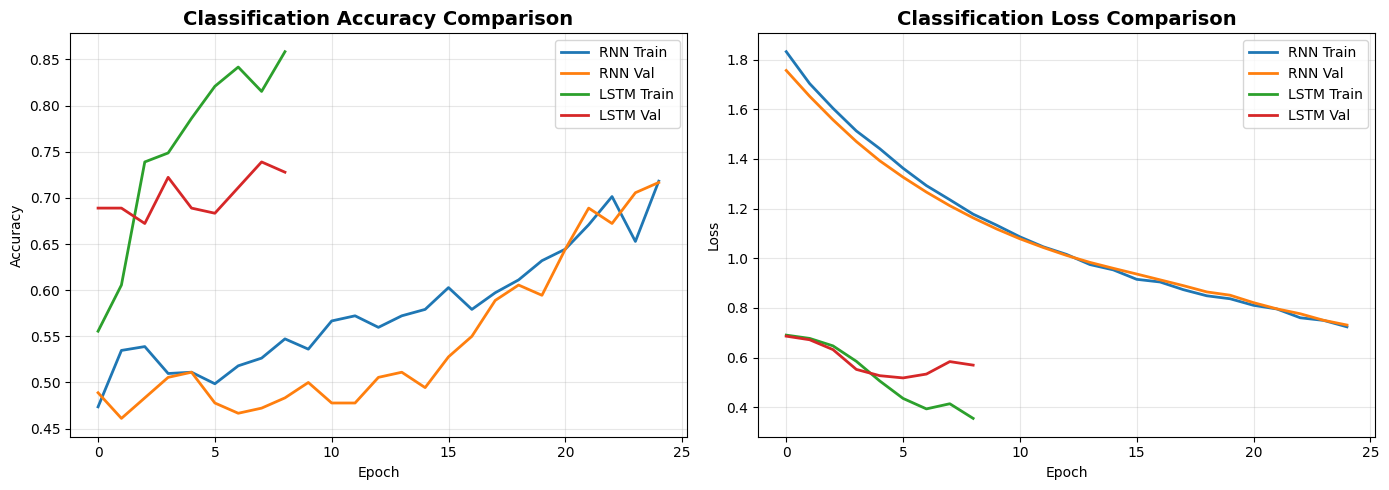

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_rnn_cls.history['accuracy'], label='RNN Train', linewidth=2)
axes[0].plot(history_rnn_cls.history['val_accuracy'], label='RNN Val', linewidth=2)
axes[0].plot(history_lstm_cls.history['accuracy'], label='LSTM Train', linewidth=2)
axes[0].plot(history_lstm_cls.history['val_accuracy'], label='LSTM Val', linewidth=2)
axes[0].set_title('Classification Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_rnn_cls.history['loss'], label='RNN Train', linewidth=2)
axes[1].plot(history_rnn_cls.history['val_loss'], label='RNN Val', linewidth=2)
axes[1].plot(history_lstm_cls.history['loss'], label='LSTM Train', linewidth=2)
axes[1].plot(history_lstm_cls.history['val_loss'], label='LSTM Val', linewidth=2)
axes[1].set_title('Classification Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()